In [2]:
# https://pypi.org/project/lda/
# https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
# http://kldavenport.com/topic-modeling-amazon-reviews/

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

# Cleaning and pre-processing
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import entropy

# Data Loading and Cleansing

In [3]:
reviews_df = pd.read_json("../../dataset/restaurant_reviews_10k.json", lines=True)
#reviews_df = pd.read_json("../../dataset/restaurant_reviews.json", lines=True)

reviews_df.head()

,business_id,cool,date,funny,stars,text,useful,user_id
0,--6MefnULPED_I942VcFNA,0,2017-08-17,0,4,This is one of my top 3 places to get BBQ pork...,2,FEg8v92qx3kK4Hu4TF28Fg
1,--6MefnULPED_I942VcFNA,0,2017-05-31,0,3,This restaurant is famous for their BBQ dishes...,0,HPtjvIrhzAUkKsiVkeT4MA
2,--6MefnULPED_I942VcFNA,0,2016-10-23,0,2,Roasted pork is one of my favorite things... A...,1,MpvqV7lQcl15rflTBEUhXA
3,--6MefnULPED_I942VcFNA,0,2017-07-30,0,2,I walked by the restaurant more than 5 years a...,1,x-Gbs8sVid3yhJIoHD6Gfw
4,--6MefnULPED_I942VcFNA,0,2017-02-07,1,2,I came here to order a roast duck over rice to...,0,7Dykd1HolQx8mKPYhYDYSg


In [4]:
print (reviews_df.shape)

(10000, 8)


In [5]:
restaurants_df = pd.read_json("../../dataset/restaurants.json", lines=True) # Full dataset
restaurants_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,581 Howe Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH
1,Richterstr. 11,"{'GoodForMeal': {'dessert': False, 'latenight'...",o9eMRCWt5PkpLDE0gOPtcQ,"[Italian, Restaurants]",Stuttgart,"{'Monday': '18:00-0:00', 'Tuesday': '18:00-0:0...",1,48.727200,9.147950,Messina,,70567,5,4.0,BW
2,737 West Pike St,"{'GoodForMeal': {'dessert': False, 'latenight'...",XOSRcvtaKc_Q5H1SAzN20A,"[Breakfast & Brunch, Gluten-Free, Coffee & Tea...",Houston,{},0,40.241548,-80.212815,East Coast Coffee,,15342,3,4.5,PA
3,600 E 4th St,"{'GoodForMeal': {'dessert': False, 'latenight'...",fNMVV_ZX7CJSDWQGdOM8Nw,"[Restaurants, American (Traditional)]",Charlotte,"{'Tuesday': '7:00-15:00', 'Friday': '7:00-15:0...",1,35.221647,-80.839345,Showmars Government Center,Uptown,28202,7,3.5,NC
4,2459 Yonge St,"{'GoodForMeal': {'dessert': False, 'latenight'...",l09JfMeQ6ynYs5MCJtrcmQ,"[Italian, French, Restaurants]",Toronto,"{'Monday': '9:00-22:00', 'Tuesday': '9:00-22:0...",0,43.711399,-79.399339,Alize Catering,Yonge and Eglinton,M4P 2H6,12,3.0,ON


In [6]:
#Add to make the notebook run - by Charlene
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Cleaning and pre-processing
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc) for doc in reviews_df.text]  
#doc_clean = reviews_df.text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenyingcharlene/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chenyingcharlene/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Topic Modeling using LDA

In [7]:
def print_top_words(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        topic_names.append(" ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return topic_names

In [8]:
n_features = 100000
n_topics = 100
n_top_words = 3

print ("Fitting Count Vectorizer")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(doc_clean)

print ("Fitting LDA")
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(tf)

Fitting Count Vectorizer
Fitting LDA


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=100, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [9]:
tf_feature_names = tf_vectorizer.get_feature_names()
topic_names = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: conos bacardi margharita
Topic #1: paratha clothing chard
Topic #2: egg breakfast matt
Topic #3: burrito tempura tony
Topic #4: tea lunch carne
Topic #5: food great place
Topic #6: tot chow muslim
Topic #7: pulao halwa steak
Topic #8: buying expand useful
Topic #9: prawn 11 char
Topic #10: 1940sish coupla diane
Topic #11: nandini avacado crumbles
Topic #12: stand der da
Topic #13: thirsty classed fufu
Topic #14: hong range brutal
Topic #15: good like ordered
Topic #16: en robuchon corona
Topic #17: byob cantonese tsos
Topic #18: burger pear chai
Topic #19: roast pittsburgh mm
Topic #20: agua tinga adobada
Topic #21: cacciatore sewing berto
Topic #22: yelp mexico zinc
Topic #23: sonic ahhhhhh copied
Topic #24: samosa pakoras chana
Topic #25: foie gras strawberry
Topic #26: delectable faux weight
Topic #27: tiki southside longtime
Topic #28: panang steak place
Topic #29: lassie babysitter und
Topic #30: fontanella chile tamale
Topic #31: lassi biryani ma
Topic #32: trout twinsb

# Building the Review-Topic Distribution Matrix

In [10]:
# Compute review-topic distribution vectors
# Each row represents a review's topic distribution
# Each column is the probability of the topic. The sum of all entries in a row should = 1.0 (becuase it's a distirbution)
review_topic = lda.transform(tf)
review_topic_df = pd.DataFrame(review_topic)
review_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000625,0.000625,0.000625,0.000625,0.000625,0.346792,0.000625,0.000625,0.000625,0.000625,...,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625
1,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,...,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500
2,0.000233,0.000233,0.198995,0.000233,0.019251,0.000233,0.000233,0.000233,0.000233,0.000233,...,0.000233,0.025644,0.000233,0.000233,0.000233,0.042060,0.000233,0.000233,0.000233,0.000233
3,0.000078,0.000078,0.021935,0.000078,0.000078,0.154298,0.000078,0.000078,0.000078,0.000078,...,0.054341,0.095256,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.023185,0.000078
4,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,...,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.097296,0.000227,0.108770,0.000227


# Visualizing Review's Topic Distribution

Review text:  This is one of my top 3 places to get BBQ pork (char siu). It is not the cheapest option, but you get what you pay for. My other go tos include Kum Hong BBQ and Skyview Fusion restaurant.
(100,)


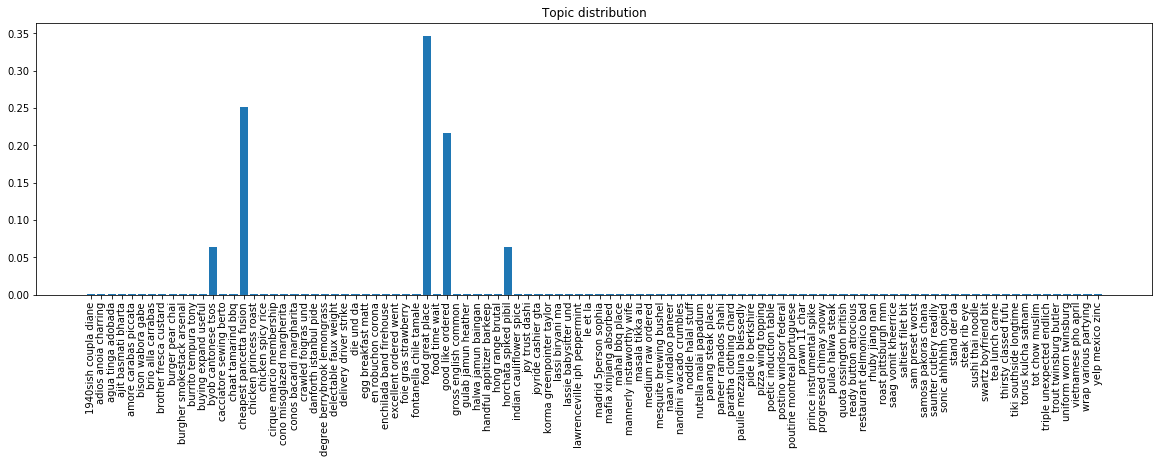

In [11]:
def display_review_topic_dist(review_id, review_topic_df):
    review_text = reviews_df.text[review_id]
    print ("Review text: ", review_text)
    review_dist = pd.DataFrame(review_topic_df.loc[review_id])
    review_dist.columns = ['dist']
    print (review_dist.dist.shape)
    
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.title("Topic distribution")
    plt.bar(topic_names, review_dist.dist)
    plt.plot()
    
display_review_topic_dist(0, review_topic_df)

Review text:  This restaurant is famous for their BBQ dishes and they are actually very good. It also has a variety of other non-BBQ dishes. Compare to other places that sell BBQ dishes, this restaurant is a bit pricey but their dishes are pretty good.
(100,)


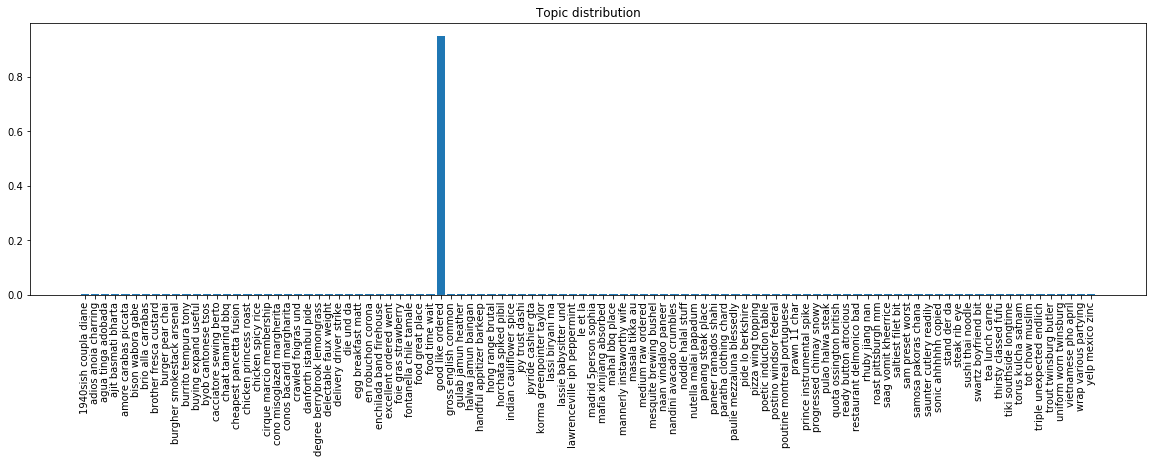

In [12]:
display_review_topic_dist(1, review_topic_df)

Review text:  Roasted pork is one of my favorite things... And we pay a premium for the meat around the ribs and the belly area because of the wonderful marbling...  beautiful layer after layer of alternating meat and fat.  My wife bought some from John's today... paid a premium for this "cut" and when I opened up the box it was all meaty pieces without marbling... Very disappointed.  The flavour was decent but not the cut we paid for.  Probably best to keep going to the BBQ place at Valleymede and HWY 7 (north side) in the plaza with McDees.
(100,)


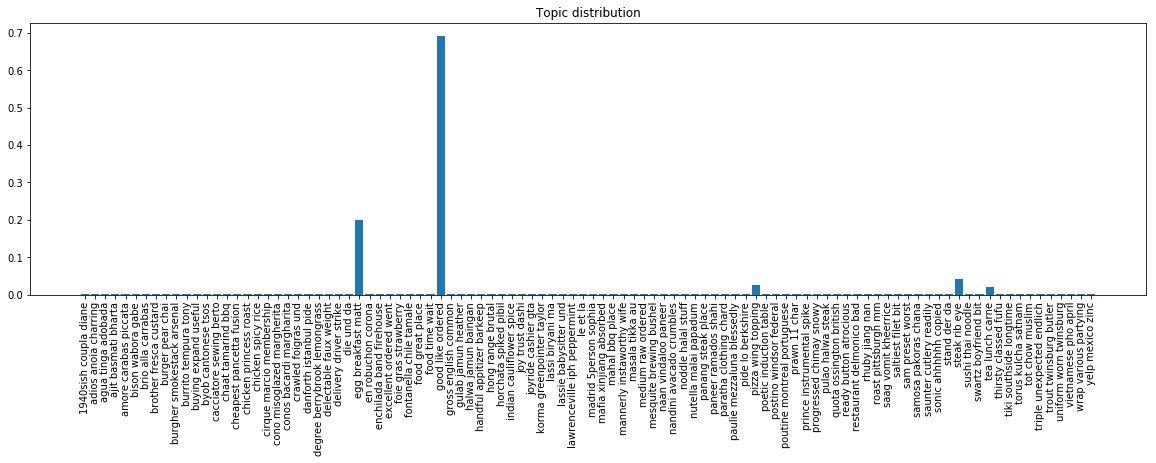

In [13]:
display_review_topic_dist(2, review_topic_df)

Review text:  I walked by the restaurant more than 5 years ago when I witnessed from the window one of the employees drop a bbq chicken wing on the floor, pick it up and place it back in the bbq meat display cabinet as if nothing happened. After that, I vowed never to come here, but after 5+ years, I figured I should try it at least once... 

I kept seeing glowing reviews here about the great char-siu wong (bbq pork king). I see comments like the best in GTA, so I had to try it out. At $28 for the made-to-order char-siu dish, I was expecting something that would be on par with the best. Sadly, I've had better bbq pork from fast food take out places (Richlane, Kum Hong BBQ, etc...). It was slightly cold, suggesting they just warmed it up. The edges were burnt, but the outer layer wasn't crispy. They put way too much honey making it too sweet. Worst of all, the pork wasn't very tender. Was quite disappointed... 

The bbq pork at Skyview fusion (Woodbine and Hwy 7) is way better. Also I w

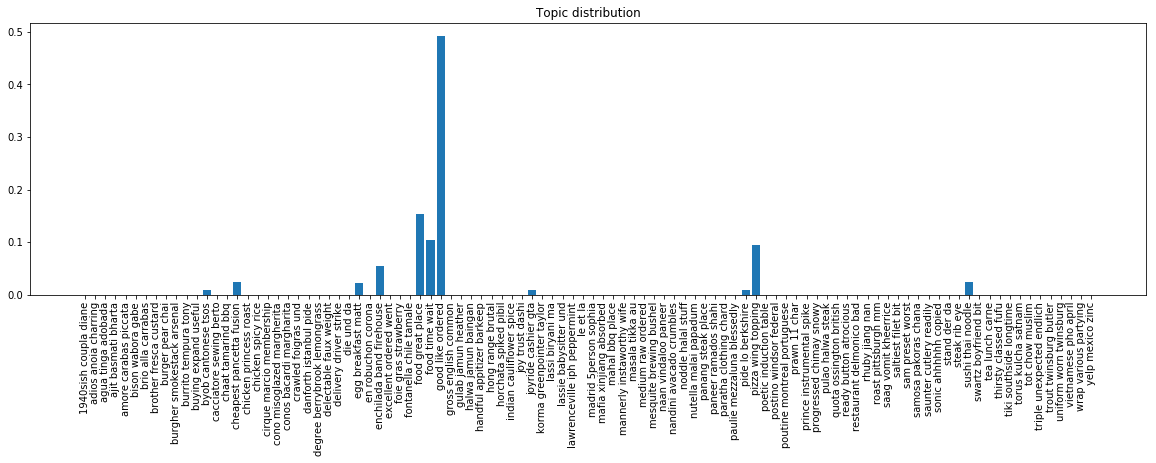

In [14]:
display_review_topic_dist(3, review_topic_df)

# Building the User Sum Rating Table

In [15]:
# Build user sum rating table
user_rating_agg_df = reviews_df.groupby('user_id')['stars'].aggregate(['sum', 'count'])
user_rating_agg_df.sort_values(by='count', ascending=False).head()

,sum,count
user_id,,
Lfv4hefW1VbvaC2gatTFWA,18,5
rCWrxuRC8_pfagpchtHp6A,12,4
-lh59ko3dxChBSZ9U7LfUw,18,4
M9TjYmTgHayJ22cNkyvW_g,16,4
0QdwQLVxZpgy9Qb2Qakflw,16,4


# Building the User-Topic Distribution Matrix

In [16]:
# 1. Iterate each user and get all the user's reviews
# 2. User A’s Topic Space = SUM( rating i / SUM rating * review i topic vector )
# 3. May want to filter out users with too little reviews, these users may not have a very representative topic distribution

user_topics = []

c = 0
for user_id in reviews_df.user_id.unique():
    user_df = reviews_df[reviews_df.user_id == user_id]
    sum_user_rating = user_rating_agg_df[user_rating_agg_df.index == user_id]['sum'][0]
    
    # Initialize user-topic distribution
    user_topic_dist = np.zeros(n_topics)
    
    for review in user_df.iterrows():
        review_id = review[0]
        rating = review[1]['stars']
        topic_dist = review_topic_df.loc[review_id]
        user_topic_dist += (rating+0.0)/sum_user_rating * topic_dist
    
    user_topics.append([user_id, user_topic_dist])

user_topics_df = pd.DataFrame(user_topics)

In [17]:
user_topics_df.columns = ['user_id', 'topic_distribution']
user_topics_df.head()

,user_id,topic_distribution
0,FEg8v92qx3kK4Hu4TF28Fg,0 0.000625 1 0.000625 2 0.000625 3...
1,HPtjvIrhzAUkKsiVkeT4MA,0 0.0005 1 0.0005 2 0.0005 3 0...
2,MpvqV7lQcl15rflTBEUhXA,0 0.000233 1 0.000233 2 0.198995 3...
3,x-Gbs8sVid3yhJIoHD6Gfw,0 0.000171 1 0.000171 2 0.014743 3...
4,7Dykd1HolQx8mKPYhYDYSg,0 0.000227 1 0.000227 2 0.000227 3...


In [18]:
user_topics_df.shape

(9636, 2)

# Visualizing Users's Topic Distribution

User ID:  Lfv4hefW1VbvaC2gatTFWA

Reviews:
Stopped by to have a quick lunch with a colleague who recommended. Nice place, not very crowded and good service. 

Had a special of the day: ravioli with grilled chicken. Very good red sauce and ravioli, chicken was kind of eh. It came with a thick piece of toasted Italian bread that was perfect with the meal.
Stopped by with a friend who had been  to IPH and wanted to go back. Very casual atmosphere with a big bar, long list of beers and many TV's.  
Ordered a fall special of Smoke & Fire that is a smoked brisket with a pepper cheese (forgot the name) and an onion ring with hand cut fries.  The brisket comes on a bun that is large and very good.  It definitely had some of the smoke flavor and some spiciness from the cheese.  We definitely enjoyed our food.  The Smoke & Fire "Handheld" sandwich cost $16.  Thought it to be good but the price seems to be a bit high, guess you are paying for the ambiance.

Oh, Yea, the WIFI sucks.  Did not work 

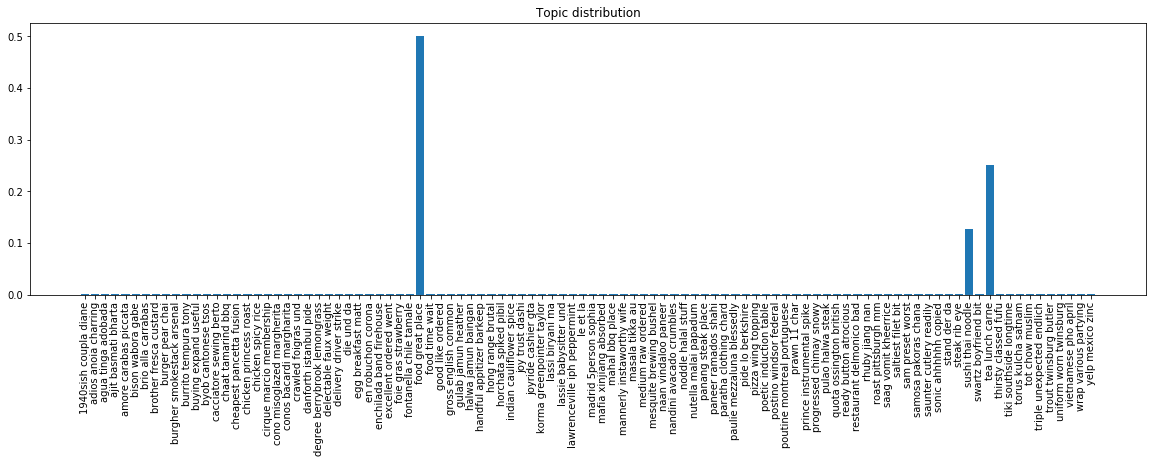

In [19]:
def display_user_topic_dist(user_id, user_topics_df):
    print ("User ID: ", user_id)
    print ("")
    
    print ("Reviews:")
    for r in reviews_df[reviews_df.user_id == user_id].iterrows():
        print (r[1].text)
    
    topic_dist = user_topics_df.loc[review_id]

    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.title("Topic distribution")
    plt.bar(topic_names, topic_dist)
    plt.plot()
    
display_user_topic_dist('Lfv4hefW1VbvaC2gatTFWA', review_topic_df)

# Build Recommender

In [20]:
# Uses symmetric Kullback–Leibler divergence
def latent_topic_similarity(user_topic_1, user_topic_2):
    return entropy(user_topic_1, user_topic_2)

In [21]:
# For a given user_id, finds the top k nearest neighbors excluding that user
def find_nn(user_id, user_topics_df, k=10):
    user_topic_dist = user_topics_df[user_topics_df.user_id == user_id].topic_distribution.iloc[0]
    
    nn_list = []
    for r in user_topics_df.iterrows():
        other_user_id = r[1].user_id
        other_topic_dist = r[1].topic_distribution
        similarity_score = latent_topic_similarity(user_topic_dist, other_topic_dist)
        
        nn_list.append([other_user_id, similarity_score])
        
    nn_df = pd.DataFrame(nn_list)
    nn_df.columns = ['user_id', 'similarity_score']
        
    # Removes the original user
    return nn_df[nn_df.user_id != user_id].sort_values(by='similarity_score', ascending=True)[:k]

find_nn('Lfv4hefW1VbvaC2gatTFWA', user_topics_df, 10)

,user_id,similarity_score
8499,DeXKbQYNx52OlOizobOLJw,0.156831
8565,X0ThBT2nXkeEFzd7RSuy6Q,0.166371
2026,6tlC85J2zsHpnrtHp3qX6Q,0.224859
5163,7p1FfxnjZAuNydjLKEW_Yg,0.232652
9421,ALLyRyHOyp4RZ1p-sZ3BdA,0.239373
6412,2gBnpLchnstAV9DvhczYew,0.247137
4702,r7GHYNcXMwCxd5SIHNBsAQ,0.251404
6381,Bj_CuoQp-8fHhVhd75N86w,0.252225
6785,D6SEKcIne80A0AhwiEV2Rg,0.254741
5173,5UYjT5YDKSuApFax2t2eqg,0.255807


In [22]:
def find_recommendations(user_id, n_restaurants=10):
    reviewed_business_ids = reviews_df[reviews_df.user_id == user_id].business_id
    nn_user_ids = find_nn(user_id, user_topics_df, 10)
    nn_user_ids = nn_user_ids.set_index('user_id')
    
    # Only recommend positive reviews
    pos_df = reviews_df[reviews_df.stars >= 4] 
    
    # Only recommend from nearest neighbors
    pos_df = pos_df.set_index('user_id')
    recommendations_df = pos_df.join(nn_user_ids, how='inner').sort_values(by='stars', ascending=False)
    
    # Remove recommendations where user has already given a review (e.g. has been to the restaurant)
    pos_df = pos_df.join(reviewed_business_ids, how='left', on='business_id', rsuffix='_r')
    pos_df = pos_df[pd.isnull(pos_df.business_id_r)]
    
    recommendations_df['recommendation_score'] = (6 - recommendations_df.stars) * recommendations_df.similarity_score
    return recommendations_df.sort_values(by='recommendation_score')

# The lower recommendation_score the better
find_recommendations('Lfv4hefW1VbvaC2gatTFWA')

,business_id,cool,date,funny,stars,text,useful,similarity_score,recommendation_score
user_id,,,,,,,,,
DeXKbQYNx52OlOizobOLJw,-8F04F54iDT6VgWPCgybug,3,2017-09-18,1,5,I was driving on Penn Ave and almost stopped i...,3,0.156831,0.156831
7p1FfxnjZAuNydjLKEW_Yg,-3oxnPPPU3YoxO9M1I2idg,3,2015-12-19,3,5,"No complaints here. The service, prices, atmos...",4,0.232652,0.232652
ALLyRyHOyp4RZ1p-sZ3BdA,-8QlV3b_9H4BAh6LgMIr1g,0,2016-05-22,0,5,A MUST VISIT!!!! \n\nWent here for the first t...,2,0.239373,0.239373
r7GHYNcXMwCxd5SIHNBsAQ,-1xuC540Nycht_iWFeJ-dw,0,2012-02-12,0,5,Not much to add about this place which has not...,3,0.251404,0.251404
Bj_CuoQp-8fHhVhd75N86w,-5NXoZeGBdx3Bdk70tuyCw,0,2012-03-28,0,5,PoBoys is great!!\n\nI had the Pulled pork piz...,0,0.252225,0.252225
X0ThBT2nXkeEFzd7RSuy6Q,-7PX_FOoCwktlunImRyZdg,0,2017-03-31,0,4,One of the best pizza places in Pittsburgh. I ...,1,0.166371,0.332743
X0ThBT2nXkeEFzd7RSuy6Q,-8F04F54iDT6VgWPCgybug,0,2017-10-21,0,4,I heard about this place from the lady that do...,0,0.166371,0.332743
7p1FfxnjZAuNydjLKEW_Yg,-6tvduBzjLI1ISfs3F_qTg,1,2015-07-31,1,4,Yummo! Went around 6:45 on a Thursday and had ...,3,0.232652,0.465305
2gBnpLchnstAV9DvhczYew,-5XuRAfrjEiMN77J4gMQZQ,0,2011-04-12,0,4,This is a common lunch stop for me. Their bean...,2,0.247137,0.494273


In [23]:
reviews_df.head()

,business_id,cool,date,funny,stars,text,useful,user_id
0,--6MefnULPED_I942VcFNA,0,2017-08-17,0,4,This is one of my top 3 places to get BBQ pork...,2,FEg8v92qx3kK4Hu4TF28Fg
1,--6MefnULPED_I942VcFNA,0,2017-05-31,0,3,This restaurant is famous for their BBQ dishes...,0,HPtjvIrhzAUkKsiVkeT4MA
2,--6MefnULPED_I942VcFNA,0,2016-10-23,0,2,Roasted pork is one of my favorite things... A...,1,MpvqV7lQcl15rflTBEUhXA
3,--6MefnULPED_I942VcFNA,0,2017-07-30,0,2,I walked by the restaurant more than 5 years a...,1,x-Gbs8sVid3yhJIoHD6Gfw
4,--6MefnULPED_I942VcFNA,0,2017-02-07,1,2,I came here to order a roast duck over rice to...,0,7Dykd1HolQx8mKPYhYDYSg


## Evaluation

In [24]:
def find_recommendations_eva(user_id, n_knn=20,similarity_score=0.16):
    reviewed_business_ids = reviews_df[reviews_df.user_id == user_id].business_id
    nn_user_ids = find_nn(user_id, user_topics_df, n_knn)
    nn_user_ids = nn_user_ids.set_index('user_id')

    # Only recommend positive reviews
    pos_df1 = reviews_df[reviews_df.stars >= 4] 
    
    # Keep recommendations where user has already given a review (e.g. has been to the restaurant)
    pos_df2 = pos_df1[pos_df1['business_id'].isin(list(reviewed_business_ids))].set_index('user_id')

    # Only recommend from nearest neighbors
    recommendations_df = pos_df2.join(nn_user_ids, how='inner').sort_values(by='stars', ascending=False)

    # generate recommended restaurants
    # 'label' means groud true, 'recommended?' means prediction
    recommend_list = list(set(recommendations_df[recommendations_df['similarity_score'] < similarity_score].business_id))
    recommend_list_df = pd.DataFrame(data = {'business_id' : recommend_list, 'recommend?': 1})
    result_df = reviews_df[reviews_df.user_id == user_id].join(recommend_list_df.set_index('business_id'), on='business_id')
    result_df['recommend?'].fillna(0, inplace=True)

    result_df.loc[result_df['stars'] >= 4, 'label'] = 1.0
    result_df.loc[result_df['stars'] < 4, 'label'] = 0.0

    return result_df.set_index('user_id')

# The lower similarity_score the better
find_recommendations_eva('Lfv4hefW1VbvaC2gatTFWA')

,business_id,cool,date,funny,stars,text,useful,recommend?,label
user_id,,,,,,,,,
Lfv4hefW1VbvaC2gatTFWA,-40RDS4F54qiGiEQUsZaXA,1,2011-08-26,0,3,Stopped by to have a quick lunch with a collea...,3,0.0,0.0
Lfv4hefW1VbvaC2gatTFWA,-7H-oXvCxJzuT42ky6Db0g,5,2015-11-10,2,4,Stopped by with a friend who had been to IPH ...,3,0.0,1.0
Lfv4hefW1VbvaC2gatTFWA,-7PX_FOoCwktlunImRyZdg,3,2015-05-06,1,4,Nice new restaurant. Friendly service. Now f...,3,0.0,1.0
Lfv4hefW1VbvaC2gatTFWA,-8F04F54iDT6VgWPCgybug,19,2017-10-02,8,4,Nice place. Like the remodel/environment. Sa...,19,1.0,1.0
Lfv4hefW1VbvaC2gatTFWA,-8ILwSisSrTzcyy_Z0o9oA,5,2014-05-05,1,3,To have a slice or a cone. If you want a cone...,5,0.0,0.0


In [25]:
# compute accuracy for one user_id

from sklearn.metrics import accuracy_score

user_id = 'Lfv4hefW1VbvaC2gatTFWA'
accuracy_score(find_recommendations_eva(user_id)['label'], find_recommendations_eva(user_id)['recommend?'])

0.6

In [ ]:
#create a dataframe of all the recommended restaurants for all users
recommend_result = pd.DataFrame()

for user_id in list(set(reviews_df.user_id))[0:10]:
    recommend_result = recommend_result.append(find_recommendations_eva(user_id))

recommend_result


In [ ]:
# compute accuracy for all

from sklearn.metrics import accuracy_score

accuracy_score(recommend_result['label'], frecommend_result['recommend?'])